In [1]:
import os
from os.path import join
from utils import get_transform, load_model, prep_for_plot, remove_axes, prep_args, normalize, unnorm
from modules import FeaturePyramidNet, DinoFeaturizer, sample
from data import ContrastiveSegDataset
import hydra
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.utilities.seed import seed_everything
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from PIL import Image ,ImageOps
from torchvision import transforms as T
import yaml
from types import SimpleNamespace

In [106]:
def res_crop_getpoint(p, img, res): 

    xp, yp = p
    w ,h = img.size
    resize = T.Resize(res, Image.NEAREST)
    cropper = T.CenterCrop(res)
    comp = T.Compose([cropper, T.ToTensor(), normalize])

    resize_image = resize(img)
    w_ , h_ = resize_image.size


    cropped_image = comp(resize_image)
    _, w__, h__ = cropped_image.size()

    if w > h : 
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

        dif = (w_ - res )//2 
        xp_ = xp_ - dif 
        
    elif h > w :
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

        dif = (h_ - res )//2 
        yp_ = yp_ - dif 
    
    else :
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

    return (xp_, yp_) , cropped_image

def res_crop_getpoint2(p, img, res): 

    xp, yp = p
    w ,h = img.size
    resize = T.Resize(res, Image.NEAREST)
    cropper = T.CenterCrop(res)
    comp = T.Compose([cropper, T.ToTensor()])

    resize_image = resize(img)
    w_ , h_ = resize_image.size


    cropped_image = comp(resize_image)
    _, w__, h__ = cropped_image.size()

    if w > h : 
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

        dif = (w_ - res )//2 
        xp_ = xp_ - dif 
        
    elif h > w :
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

        dif = (h_ - res )//2 
        yp_ = yp_ - dif 
    
    else :
        yp_ = yp * h_ // h
        xp_ = xp * w_ // w

    return (xp_, yp_) , cropped_image

def getPatch(p, patch_size):
    x, y = p
    return x//patch_size, y//patch_size

In [3]:
@hydra.main(config_path="configs", config_name="train_config.yaml")
def my_app(cfg: DictConfig) -> None:
    pytorch_data_dir = cfg.pytorch_data_dir
    data_dir = join(cfg.output_root, "data")
    
    
    vclass = 'boat'
    # Annotations 
    annotations = cfg.annotations
    temp_annotations = dict()
    temp_annotations[vclass] = annotations[vclass]
    annotations = temp_annotations
    
    res = cfg.res
    patch_size = cfg.dino_patch_size
    feats_res = res // patch_size 
    net = DinoFeaturizer(cfg.dim, cfg)
    net = net.cuda()

    point_data = dict()
    cls_mask = [] 
    for cls_cnt, pcls in enumerate(annotations.keys()) : 
        curr_cls = annotations[pcls]
        annot_points = torch.zeros((len(curr_cls),2))
        annot_patch_coords = torch.zeros((len(curr_cls),2)) 
        annot_feat_vectors = torch.zeros((len(curr_cls),cfg.vit_dim)) 
        annot_ref_feats = torch.zeros((len(curr_cls),cfg.vit_dim, feats_res, feats_res))
        
        for cnt ,annot in enumerate(curr_cls): 
            point_img_path = annot[0]
            orig_x = annot_points[cnt,0] = annot[1]
            orig_y = annot_points[cnt,1] = annot[2]
            
                            
            raw_img = Image.open(point_img_path)
            (target_x, target_y), img = res_crop_getpoint((orig_x, orig_y), raw_img, res)
            
            
            feats, _, _ = net(img.unsqueeze(0).cuda())
            
            annot_ref_feats[cnt,:,:,:] = feats.squeeze(0)
            
            patch_i, patch_j = getPatch((target_x, target_y), patch_size)
            annot_patch_coords[cnt,0] = patch_i
            annot_patch_coords[cnt,1] = patch_j
            print(pcls,cnt)
            vector_point = feats[:, :, patch_j, patch_i]
            annot_feat_vectors[cnt,:] = vector_point.squeeze(0)
            cls_mask.append(cls_cnt)

            
        point_data[pcls]= {
            'feature_vectors' : annot_feat_vectors,
            'point' : annot_points, 
            'patch_coord' : annot_patch_coords,
            'ref_feats': annot_ref_feats
        }
            
    
    sum_feature_vectors = [point_data[pcls]['feature_vectors'] for pcls in annotations.keys()]
    sum_point = [point_data[pcls]['point'] for pcls in annotations.keys()]
    sum_patch_coord = [point_data[pcls]['patch_coord'] for pcls in annotations.keys()] 
    sum_ref_feats = [point_data[pcls]['ref_feats'] for pcls in annotations.keys()]
    
    sum_feature_vectors = torch.cat(sum_feature_vectors, dim=0)
    sum_point = torch.cat(sum_point, dim=0)
    sum_patch_coord = torch.cat(sum_patch_coord, dim=0)
    sum_ref_feats = torch.cat(sum_ref_feats, dim=0)
    
    point_data['sum'] = {
        'feature_vectors' : sum_feature_vectors,
        'point': sum_point,
        'patch_coord': sum_patch_coord,
        'ref_feats' : sum_ref_feats,
        'class_mask' :  cls_mask
    }

/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  """Entry point for launching an IPython kernel.


In [4]:
file_path = '/media/c15924-FastData/dtzimas/code/OneShot/stego/src/configs/train_config.yaml'

# Reading the YAML file
with open(file_path, 'r') as file:
    config_dict = yaml.safe_load(file)
cfg = SimpleNamespace(**config_dict)


In [62]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

dinov2_vits14 = dinov2_vits14.cuda()

Using cache found in /home/dtzimas/.cache/torch/hub/facebookresearch_dinov2_main


In [90]:
img = torch.rand(1,3,224,224).cuda()
x = dinov2_vits14.get_intermediate_layers(img)
x[0].size()

torch.Size([1, 256, 384])

In [115]:
patch_size = 14

def net(x):
    out = dinov2_vits14.get_intermediate_layers(x)[0]
    out = out.permute(0,2,1)
    out = out.resize(out.shape[0],out.shape[1],int(out.shape[2]**0.5),int(out.shape[2]**0.5))
    return out, None , None
net(img)[0]

/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[[[ 1.6656,  1.9698,  2.2090,  ...,  1.6726,  2.0101,  1.6494],
          [ 2.6375,  2.2143,  2.5557,  ...,  2.3693,  2.6404,  2.0142],
          [ 2.0919,  3.8258,  3.2259,  ...,  2.5293,  3.5150,  2.2900],
          ...,
          [ 2.0345,  3.6422,  2.8626,  ...,  3.4343,  3.8025,  2.3081],
          [ 2.6377,  2.3833,  3.1952,  ...,  3.1353,  2.4940,  2.3373],
          [ 2.2326,  2.3484,  2.0863,  ...,  2.3143,  2.1038,  2.0479]],

         [[-1.4722, -2.2973, -5.6693,  ..., -0.2012,  1.0042,  2.9075],
          [ 0.5753,  0.0720, -0.8344,  ...,  3.5377,  3.6503,  5.3925],
          [ 1.5667,  0.2319, -2.2680,  ...,  6.5499,  6.9774,  8.5095],
          ...,
          [-1.1232, -2.2015, -6.2893,  ...,  1.5117,  3.7607,  5.3259],
          [-2.0520, -0.9469, -2.6705,  ...,  1.1341,  2.6982,  3.8473],
          [-4.2777, -2.4608, -7.0167,  ..., -1.5711,  0.5534,  1.1348]],

         [[-2.2647, -1.4504, -2.1502,  ..., -1.0472, -1.0374, -0.6541],
          [-1.7205, -1.5030, -

In [60]:
res = cfg.res
patch_size = cfg.dino_patch_size
feats_res = res // patch_size 
net = DinoFeaturizer(cfg.dim, cfg)

net = net.eval().cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [79]:
p = (772, 990)
# raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/001_rgb.png')
# raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/FloodStego/imgs/train/46.jpg')
raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/simarStego/imgs/train/IMG_8106_644.jpg')
raw_img = ImageOps.exif_transpose(raw_img)

print(raw_img.size)
# raw_img = Image.open('//media/c15924-FastData/dtzimas/datasets/VocStego/imgs/train/2007_000256.jpg')

(target_x, target_y), img = res_crop_getpoint((p[0], p[1]), raw_img, res)
print(img.unsqueeze(0).size())
feats, _, _  = net(img.unsqueeze(0).cuda())

patch_i, patch_j = getPatch((target_x, target_y), patch_size)
gt_vector = feats[:,:,patch_j,patch_i].squeeze(0)
feats = feats.squeeze(0)


(1080, 1920)
torch.Size([1, 3, 224, 224])


/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


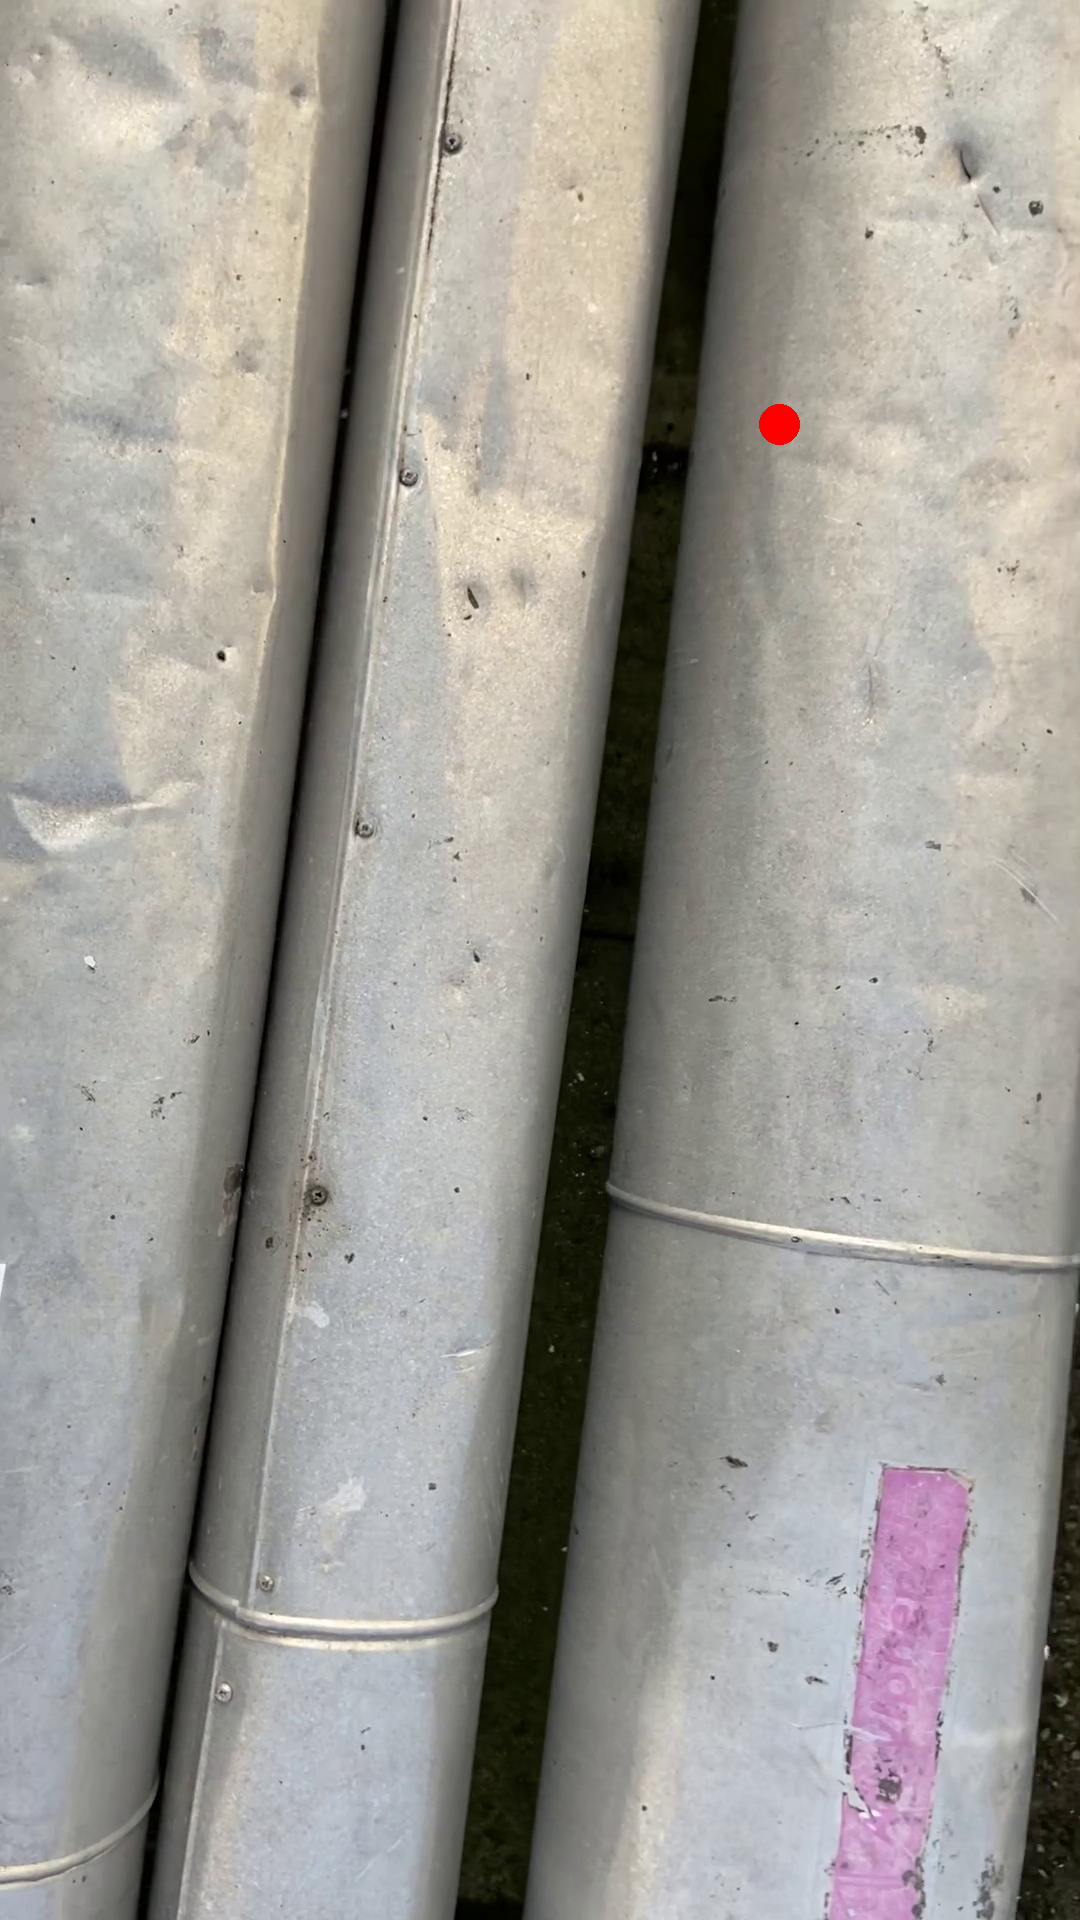

In [8]:
from PIL import Image, ImageDraw

def dpoint(img, point_position):
    draw = ImageDraw.Draw(img)

    # Define the point's color
    point_color = "red"
    # Define the point size (radius)
    point_size = 20
    # Draw the point (as a small circle)
    draw.ellipse(
        [
            (point_position[0] - point_size, point_position[1] - point_size),
            (point_position[0] + point_size, point_position[1] + point_size)
        ], 
        fill=point_color
    )
    return img

# temp = raw_img
# for p in np.flip(ps) : 
#     temp = dpoint(temp.copy(),p)
# temp
p = (779, 424)
dpoint(raw_img.copy(),p)

In [9]:
3024-2458

566

In [54]:
def get_sim(raw_img, tag_raw_img, p=(100,100)):

    (target_x, target_y), img = res_crop_getpoint((p[0], p[1]), raw_img, res)
    feats, _, _  = net(img.unsqueeze(0).cuda())
    patch_i, patch_j = getPatch((target_x, target_y), patch_size)
    gt_vector = feats[:,:,patch_j,patch_i].squeeze(0)
    feats = feats.squeeze(0)

    (target_x, target_y), tag_img = res_crop_getpoint((p[0], p[1]), tag_raw_img, res)
    tag_feats, _, _  = net(tag_img.unsqueeze(0).cuda())

    tag_feats = tag_feats.squeeze(0)

    sim = torch.einsum('chw,c->hw',F.normalize(tag_feats,dim=0),F.normalize(gt_vector,dim=0))
    # print(f'MEAN {torch.mean(sim)}')
    # print(f'VAR {torch.var(sim)}')
    # print(f'STD {torch.std(sim)}')
    # print(f'MAX {torch.max(sim.flatten())}')
    # print(f'MIN {torch.min(sim.flatten())}')
    # print(torch.equal(feats,tag_feats))
    # plt.imshow(sim.cpu())
    return sim.cpu()

# p = (160,600)
p = (85,207)
raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/106_rgb.png')
raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/FloodStego/imgs/train/image_431.jpg')

tag_raw_img = raw_img
# tag_raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/106_rgb.png')
# tag_raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/FloodStego/imgs/train/3.jpg')
sim = get_sim(raw_img,tag_raw_img,p)

/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[[0.03721739]
 [0.4784672 ]]
Code block 1 execution time: 0.0376 seconds


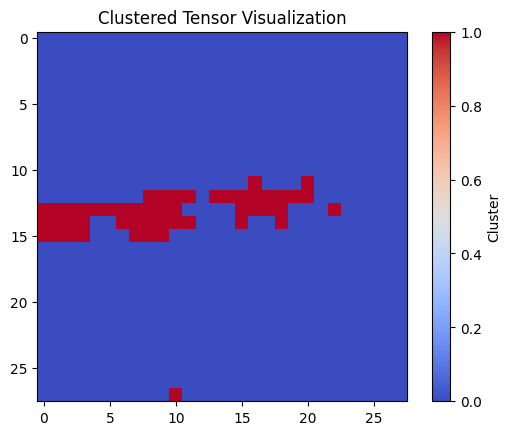

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
start_time = time.time()

# Step 1: Generate or use your similarity tensor in PyTorch (h, w)
h, w = 28, 28  # Example size
similarity_tensor = sim  # Replace with your actual tensor

# Step 2: Flatten the tensor (convert it to a 1D array)
flattened_tensor = similarity_tensor.flatten().numpy()  # Convert to NumPy for KMeans

# Step 3: Apply K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2,init=np.array([0.05, 0.5]).reshape(-1,1),n_init=1)
kmeans.fit(flattened_tensor.reshape(-1, 1))  # Reshape for clustering
print(kmeans.cluster_centers_)
# Get the cluster labels for each element
cluster_labels = kmeans.labels_

# Step 4: Reshape the cluster labels back to (h, w)
clustered_tensor = cluster_labels.reshape(h, w)
end_time = time.time()
print(f"Code block 1 execution time: {end_time - start_time:.4f} seconds")

# Step 5: Visualize the results using a heatmap
plt.imshow(clustered_tensor, cmap='coolwarm')  # Visualize with two colors for two clusters
plt.colorbar(label='Cluster')
plt.title('Clustered Tensor Visualization')
plt.show()

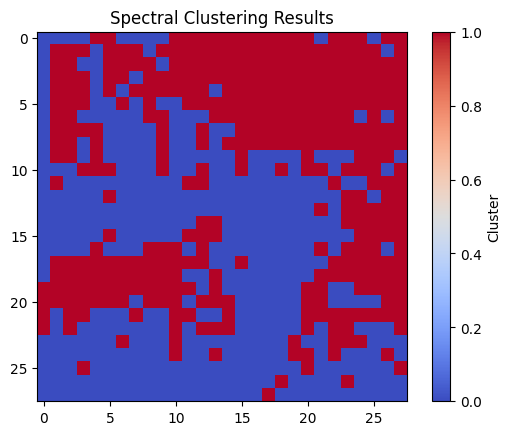

In [12]:
from sklearn.cluster import SpectralClustering

# Step 1: Generate or use your similarity tensor in PyTorch (h, w)
h, w = 28, 28  # Example size
similarity_tensor = sim  # Replace with your actual tensor

# Step 2: Flatten the tensor
flattened_tensor = similarity_tensor.flatten().numpy()

# Step 3: Apply Spectral Clustering with 2 clusters
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
cluster_labels = spectral.fit_predict(flattened_tensor.reshape(-1, 1))

# Step 4: Reshape the cluster labels back to (h, w)
clustered_tensor = cluster_labels.reshape(h, w)

# Step 5: Visualize the results using a heatmap
plt.imshow(clustered_tensor, cmap='coolwarm')
plt.colorbar(label='Cluster')
plt.title('Spectral Clustering Results')
plt.show()

1


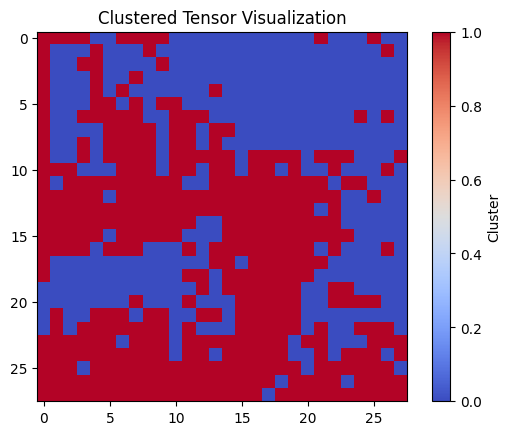

In [13]:
## check if custer with label 1 is on max simi 
val, ind = torch.max(sim.flatten(),dim=0)


if cluster_labels[ind] == 0 : 
    updated_cluster_labels = (1 - cluster_labels)
else : 
    updated_cluster_labels = cluster_labels
print(updated_cluster_labels[ind])
clustered_tensor = updated_cluster_labels.reshape(h, w)

# Step 5: Visualize the results using a heatmap
plt.imshow(clustered_tensor, cmap='coolwarm')  # Visualize with two colors for two clusters
plt.colorbar(label='Cluster')
plt.title('Clustered Tensor Visualization')
plt.show()


In [14]:
cluster_sim = clustered_tensor * similarity_tensor.numpy()
cluster_sim.shape

(28, 28)

In [15]:
new_cluster_sim = np.where(cluster_sim>0.01, cluster_sim, cluster_sim+1)

In [16]:
nonnegclust = []
for i in range(cluster_sim.shape[0]):
    for j in range(cluster_sim.shape[1]): 
        if cluster_sim[i][j] > 0.01 : 
            nonnegclust.append(cluster_sim[i][j])

nonnegclust = np.array(nonnegclust)
print(np.min(nonnegclust))
print(np.mean(nonnegclust))
print(np.max(nonnegclust)) 


0.025726404041051865
0.14720268100681386
0.9999998807907104


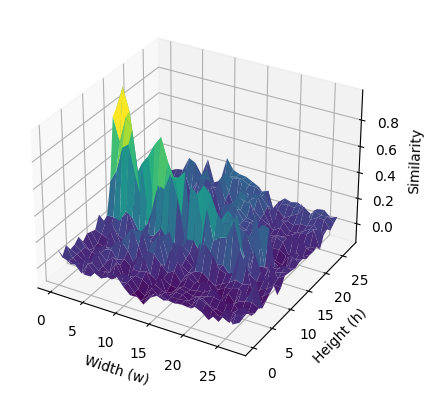

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

h, w = 28, 28
similarity_tensor = sim.numpy()
X, Y = np.meshgrid(np.arange(w), np.arange(h))
Z = similarity_tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Width (w)')
ax.set_ylabel('Height (h)')
ax.set_zlabel('Similarity')
plt.show()

## create Kmeans function for shift 

In [116]:
def shift_from_sim(sim): 
    start_time = time.time()

    h, w = sim.shape[0], sim.shape[1]  # Example size
    similarity_tensor = sim  # Replace with your actual tensor

    # Step 2: Flatten the tensor (convert it to a 1D array)
    flattened_tensor = similarity_tensor.detach().flatten().numpy()  # Convert to NumPy for KMeans

    # Step 3: Apply K-Means clustering with 2 clusters
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(flattened_tensor.reshape(-1, 1))  # Reshape for clustering

    # Get the cluster labels for each element
    cluster_labels = kmeans.labels_

    # Step 4: Reshape the cluster labels back to (h, w)
    clustered_tensor = cluster_labels.reshape(h, w)
    val, ind = torch.max(sim.flatten(),dim=0)

    if cluster_labels[ind] == 0 : 
        updated_cluster_labels = (1 - cluster_labels)
    else : 
        updated_cluster_labels = cluster_labels

    clustered_tensor = updated_cluster_labels.reshape(h, w)

    cluster_sim = clustered_tensor * similarity_tensor.detach().numpy()
    new_cluster_sim = np.where(cluster_sim>0.01, cluster_sim, cluster_sim+1)
    nonnegclust = []
    for i in range(cluster_sim.shape[0]):
        for j in range(cluster_sim.shape[1]): 
            if cluster_sim[i][j] > 0.01 : 
                nonnegclust.append(cluster_sim[i][j])

    nonnegclust = np.array(nonnegclust)
    print(np.min(nonnegclust))
    print(np.mean(nonnegclust))
    print(np.max(nonnegclust)) 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Code block 1: {elapsed_time:.4f} seconds")

shift_from_sim(sim)

0.014675617218017578
0.2611457332692764
1.0
Elapsed time for Code block 1: 0.4849 seconds


In [155]:
import torch
from sklearn.mixture import GaussianMixture
import time 
def compute_and_plot_gmm_centroids(tensor_2d):
    # Flatten the 2D tensor
    start_time = time.time()

    flattened_tensor = tensor_2d.flatten().reshape(-1, 1).numpy()
    
    # Apply Gaussian Mixture Model with 2 components
    # gmm = GaussianMixture(n_components=2,means_init=[[0.04],[0.25]],random_state=0)
    gmm = GaussianMixture(
        means_init=[[0.04],[0.3]],
        n_components=2,            # Only two components
        covariance_type="diag",     # Diagonal covariance, faster for 1D
        tol=1e-3,                   # Default tolerance, balanced speed/accuracy
        reg_covar=1e-6,             # Regularization to handle numerical stability
        max_iter=50,                # Reduced max iterations for faster results
        n_init=1,                   # Single initialization to save time
        init_params="random",       # KMeans initialization for faster convergence
        random_state=42             # Ensures reproducibility
    )
    gmm.fit(flattened_tensor)
    
    # Get the centroids (means of the two Gaussian components)
    centroids = gmm.means_.flatten()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Code block 1: {elapsed_time:.4f} seconds")
    # Plotting the data and centroids
    plt.figure(figsize=(16, 6))
    plt.hist(flattened_tensor, bins=30, color='lightblue', alpha=0.6, edgecolor='black', density=True, label="Data Histogram")
    
    # Generate range of values for Gaussian plots
    x = np.linspace(flattened_tensor.min(), flattened_tensor.max(), 500).reshape(-1, 1)
    log_prob = gmm.score_samples(x)
    pdf = np.exp(log_prob)  # Convert log-probability to probability density
    
    # Plot GMM components
    plt.plot(x, pdf, color='red', lw=2, label="Gaussian Mixture Model")
    
    # Plot centroids
    for centroid in centroids:
        plt.axvline(x=centroid, color='green', linestyle='--', lw=2, label=f"Centroid: {centroid:.2f}")

    plt.axvline(x=np.mean(centroids), color='black', linestyle='--', lw=3, label=f"Patch Threshold")

    
    plt.xlabel("Similarity Value")
    plt.ylabel("Density")
    plt.legend(fontsize="20")
    plt.title("Gaussian Mixture Model with 2 Components and Centroids")
    plt.show()
    
    return centroids

In [145]:
def get_sim(raw_img, tag_raw_img, p=(100,100)):

    (target_x, target_y), img = res_crop_getpoint2((p[0], p[1]), raw_img, res)
    feats, _, _  = net(img.unsqueeze(0).cuda())
    patch_i, patch_j = getPatch((target_x, target_y), patch_size)
    gt_vectors = [] 
    
    gt_vector = feats[:,:,patch_j,patch_i].squeeze(0)
    gt_vectors.append(gt_vector)

    feats = feats.squeeze(0)

    (target_x, target_y), tag_img = res_crop_getpoint2((p[0], p[1]), tag_raw_img, res)
    tag_feats, _, _  = net(tag_img.unsqueeze(0).cuda())

    tag_feats = tag_feats.squeeze(0)

    sim = torch.einsum('chw,c->hw',F.normalize(tag_feats,dim=0),F.normalize(gt_vector,dim=0))
    return sim.detach().cpu() ,img

/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([16, 16])
0.3509737253189087
0.6039619512772292
0.9999999403953552
Elapsed time for Code block 1: 0.0156 seconds


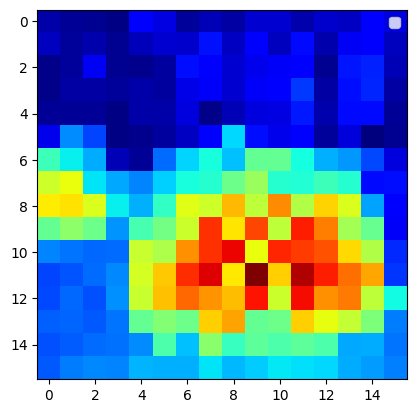

In [146]:

ps = [(1120,740)] 
# ps = [(659,400)]

raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/CityStego/imgs/train/dusseldorf_000045_000019_leftImg8bit.png')
# raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/001_rgb.png')

raw_img = ImageOps.exif_transpose(raw_img)
tag_raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/025_rgb.png')
tag_raw_img = ImageOps.exif_transpose(tag_raw_img)
tag_raw_img = raw_img
sims = []
maxes = [] 
for p in ps : 
    sim, imgcurr = get_sim(raw_img,tag_raw_img,p)
    print(sim.size())
    val, ind = torch.max(sim.reshape(sim.shape[0]*sim.shape[1]),dim=0)
    sims.append(sim)
    
sim = torch.stack(sims,dim=0)

# sim = torch.max(sim,dim=0).values
sim = torch.mean(sim,dim=0)
# T.functional.to_pil_image(unnorm(imgcurr))
# centr = compute_and_plot_gmm_centroids(sim)
shift_from_sim(sim)
# plt.imshow(sim.detach(),cmap='jet')
plt.imshow(sim.detach(),cmap='jet')

plt.legend()
plt.show()

[[0.09080806]
 [0.6039618 ]]
Code block 1 execution time: 0.0319 seconds


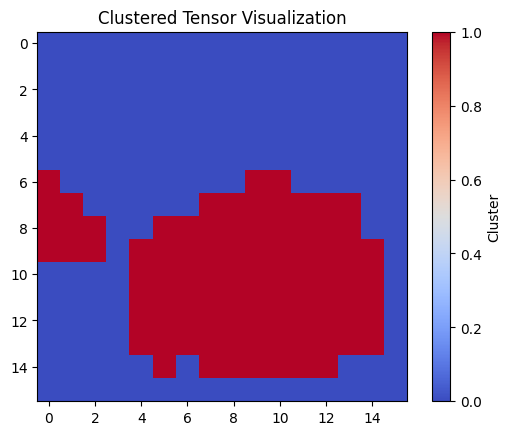

In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
start_time = time.time()

# Step 1: Generate or use your similarity tensor in PyTorch (h, w)
h, w = 16, 16  # Example size
similarity_tensor = sim  # Replace with your actual tensor

# Step 2: Flatten the tensor (convert it to a 1D array)
flattened_tensor = similarity_tensor.flatten().numpy()  # Convert to NumPy for KMeans

# Step 3: Apply K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2,init=np.array([0.05, 0.5]).reshape(-1,1),n_init=1)
kmeans.fit(flattened_tensor.reshape(-1, 1))  # Reshape for clustering
print(kmeans.cluster_centers_)
# Get the cluster labels for each element
cluster_labels = kmeans.labels_

# Step 4: Reshape the cluster labels back to (h, w)
clustered_tensor = cluster_labels.reshape(h, w)
end_time = time.time()
print(f"Code block 1 execution time: {end_time - start_time:.4f} seconds")
# Step 5: Visualize the results using a heatmap
plt.imshow(clustered_tensor, cmap='coolwarm')  # Visualize with two colors for two clusters
plt.colorbar(label='Cluster')
plt.title('Clustered Tensor Visualization')
plt.show()

Elapsed time for Code block 1: 0.0033 seconds


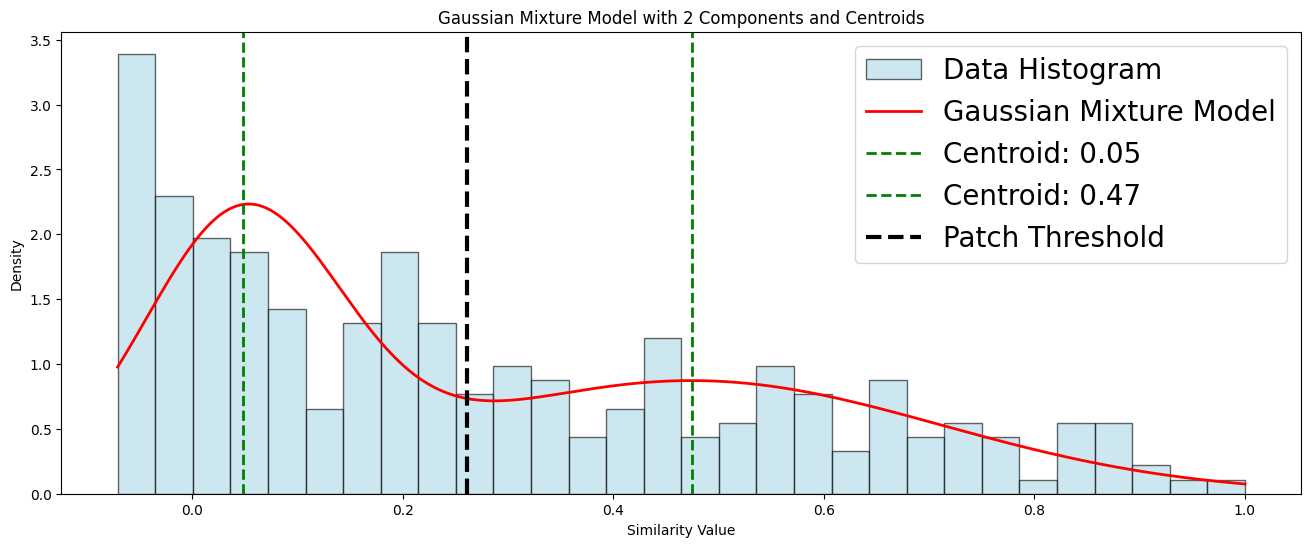

In [156]:
centr = compute_and_plot_gmm_centroids(sim)


(1200, 1)
Means: [ 0.73457271 -0.40220525]
Variances: [0.17391025 0.21920782]


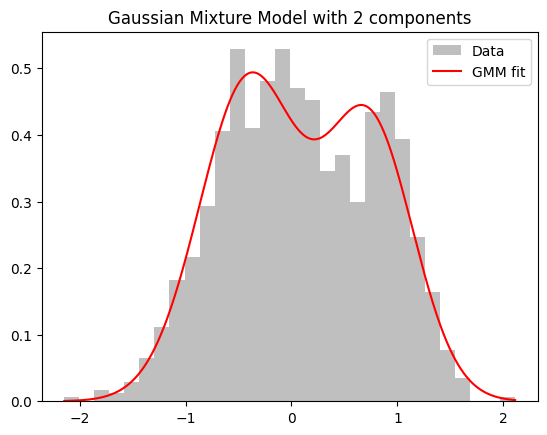

In [135]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Generate some data from two normal distributions
np.random.seed(42)
mean1, std1, size1 = -0.2, 0.6, 900  # First distribution
mean2, std2, size2 = 0.9, 0.3, 300  # Second distribution

# Generate random samples
data1 = np.random.normal(mean1, std1, size1)
data2 = np.random.normal(mean2, std2, size2)

# Combine the two datasets into one
data = np.concatenate([data1, data2])

# Reshape the data to fit into the GMM (sklearn expects 2D data)
data = data.reshape(-1, 1)
print(data.shape)
# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)

# Extract the means of the two distributions
means = gmm.means_
variances = gmm.covariances_

print(f"Means: {means.flatten()}")
print(f"Variances: {variances.flatten()}")

# Plot the original data and the fitted Gaussian components
x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data')
plt.plot(x, pdf, label='GMM fit', color='red')
plt.legend()
plt.title('Gaussian Mixture Model with 2 components')
plt.show()

In [25]:
import torch
c=torch.rand((8,24,24,24,24))
d=c.flatten()
torch.mean(d)


tensor(0.5003)

In [26]:

ps = [(481, 425), ( 445, 444)]
# ps = [(772, 990),(503, 989),(779, 424),( 880, 672),(969, 412),(847, 1040),( 1011, 209),(769, 316),(462, 870),(982, 351)]
# ps = [(662, 1027), (758, 1056), (760, 433), (949, 1078), (440, 220), (966, 1014), (575, 332), (884, 97), (432, 904), (998, 1028)]

ps = [(756, 426),(447, 275),(415 ,256),(433,331)]
# ps = [(502, 481)]

# raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/044_rgb.png')
raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/001_rgb.png')
raw_img = ImageOps.exif_transpose(raw_img)
tag_raw_img = Image.open('/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train/001_rgb.png')
tag_raw_img = ImageOps.exif_transpose(tag_raw_img)
# tag_raw_img = raw_img
sims = []
maxes = [] 
for p in ps : 
    sim = get_sim(raw_img,tag_raw_img,p)
    val, ind = torch.max(sim.reshape(sim.shape[0]*sim.shape[1]),dim=0)
    sims.append(sim)
    
sim = torch.stack(sims,dim=0)

sim = torch.max(sim,dim=0).values
# sim = torch.mean(sim,dim=0)
shift_from_sim(sim)
plt.imshow(sim,cmap='jet')
plt.legend()
plt.show()

/media/c15924-FastData/dtzimas/.conda/envs/stego/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


AttributeError: 'tuple' object has no attribute 'reshape'

In [ ]:
feature_cache_file = "/media/c15924-FastData/dtzimas/datasets/nns/nns_vit_small_fireStego_train_None_224.npz"
loaded = np.load(feature_cache_file)
nns = loaded["nns"]
nns.shape

(100, 30)

In [ ]:
train_path = "/media/c15924-FastData/dtzimas/datasets/fireStego/imgs/train"
train_dir = sorted(os.listdir(train_path))
for i, img in enumerate(train_dir): 
    if img == "516_rgb.png":
        print(i)

44


In [ ]:
tpf = 1233319
fp = 981055
fn = 280081
tpb = 24846345

bmiou = tpf/(tpf+fp+fn)
fmiou = tpb/(tpb+fp+fn)

print(f' Miou Foreground {fmiou}')
print(f' Miou Background {bmiou}')
print(f'MeanIou {(fmiou +bmiou)/2}')


 Miou Foreground 0.9516944587645204
 Miou Background 0.49442423294868015
MeanIou 0.7230593458566003
